In [ ]:
!pip install numerapi
!pip install catboost

In [ ]:
import os
import gc
import csv
import scipy
import numerapi
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
import json

In [ ]:
def read_csv(filepath):
    with open(filepath, 'r') as f:
        column_names = next(csv.reader(f))
        dtypes = {x: np.float16 for x in column_names if
                  x.startswith(('feature', 'target'))}
    return pd.read_csv(filepath, dtype=dtypes)

TARGET_NAME = f"target"
PREDICTION_NAME = f"prediction"
napi = numerapi.NumerAPI()
# download data
print("Loading data")
napi.download_current_dataset(unzip=True)
#getting the latest round information
currentr = napi.get_current_round()
LatestRound = os.path.join('numerai_dataset_'+str(currentr))
print("Current Round",currentr)
# The training data is used to train your model how to predict the targets.
training_data = read_csv(os.path.join(LatestRound, "numerai_training_data.csv")).set_index("id")
# The tournament data is the data that Numerai uses to evaluate your model.
tournament_data = read_csv(os.path.join(LatestRound, "numerai_tournament_data.csv")).set_index("id")

example_preds = read_csv(os.path.join(LatestRound, "example_predictions.csv"))
validation_data = tournament_data[tournament_data.data_type == "validation"]

feature_names = [f for f in training_data.columns if f.startswith("feature")]
print(f"Loaded {len(feature_names)} features")
cols = feature_names+['TARGET_NAME']

Downloads and sort our data

In [ ]:
#Using default parameters in CatBoost on GPU
params = {'task_type': 'GPU' }
model = CatBoostRegressor(**params)
model.fit(training_data[feature_names].astype(np.float64), training_data[TARGET_NAME].astype(np.float64),eval_set=(validation_data[feature_names].astype(np.float64), validation_data[TARGET_NAME].astype(np.float64)))

Learning rate set to 0.121554
0:	learn: 0.2232465	test: 0.2234855	best: 0.2234855 (0)	total: 25.3ms	remaining: 25.3s
1:	learn: 0.2232261	test: 0.2234808	best: 0.2234808 (1)	total: 41.1ms	remaining: 20.5s
2:	learn: 0.2232106	test: 0.2234757	best: 0.2234757 (2)	total: 56.3ms	remaining: 18.7s
3:	learn: 0.2231938	test: 0.2234753	best: 0.2234753 (3)	total: 72.4ms	remaining: 18s
4:	learn: 0.2231775	test: 0.2234740	best: 0.2234740 (4)	total: 88.2ms	remaining: 17.5s
5:	learn: 0.2231596	test: 0.2234680	best: 0.2234680 (5)	total: 103ms	remaining: 17.1s
6:	learn: 0.2231410	test: 0.2234647	best: 0.2234647 (6)	total: 119ms	remaining: 16.8s
7:	learn: 0.2231255	test: 0.2234638	best: 0.2234638 (7)	total: 137ms	remaining: 16.9s
8:	learn: 0.2231127	test: 0.2234616	best: 0.2234616 (8)	total: 152ms	remaining: 16.7s
9:	learn: 0.2230985	test: 0.2234607	best: 0.2234607 (9)	total: 166ms	remaining: 16.5s
10:	learn: 0.2230882	test: 0.2234589	best: 0.2234589 (10)	total: 179ms	remaining: 16.1s
11:	learn: 0.223074

Trains our model using a boost method from the catboost library 

In [ ]:
def spearman(y_true, y_pred): 
    return spearmanr(y_pred, y_true).correlation 

Generating predictions on training data
Generating predictions on tournament data
training performance over time


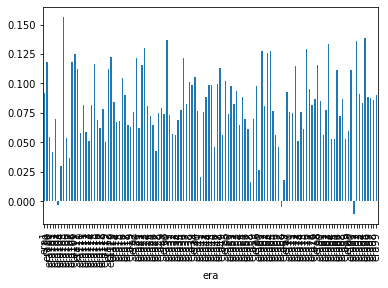

On training the correlation has mean 0.08025463056674571 and std 0.03127177993511118
On training the average per-era payout is 0.08025463056674571
training performance over time


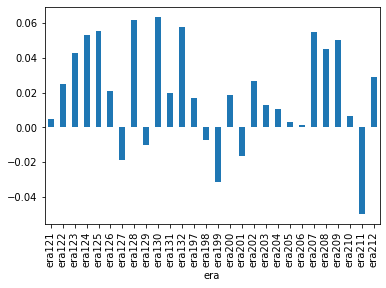

On validation the correlation has mean 0.019547362197270508 andstd 0.029885146672972436
On validation the average per-era payout is 0.019547362197270508


In [ ]:
print("Generating predictions on training data")
training_preds = model.predict(training_data[feature_names].astype(np.float64))
training_data[PREDICTION_NAME] = training_preds
gc.collect()

print("Generating predictions on tournament data")
tournament_preds = model.predict(tournament_data[feature_names].astype(np.float64))
tournament_data[PREDICTION_NAME] = tournament_preds

def correlation(predictions, targets):
    ranked_preds = predictions.rank(pct=True, method="first")
    return np.corrcoef(ranked_preds, targets)[0, 1]

def score(df):
    return correlation(df[PREDICTION_NAME], df[TARGET_NAME])

def payout(scores):
    return scores.clip(lower=-0.25, upper=0.25)

# Check the per-era correlations on the training set (in sample)
train_correlations = training_data.groupby("era").apply(score)
train_correlations.plot(kind="bar")
print("training performance over time")
plt.show() 
print(f"On training the correlation has mean {train_correlations.mean()} and std {train_correlations.std()}")
print(f"On training the average per-era payout is {payout(train_correlations).mean()}")

# Check the per-era correlations on the validation set (out of sample)
validation_data = tournament_data[tournament_data.data_type == "validation"]
validation_correlations = validation_data.groupby("era").apply(score)
validation_correlations.plot(kind="bar")
print("training performance over time")
plt.show() 
print(f"On validation the correlation has mean {validation_correlations.mean()} and" f"std {validation_correlations.std()}")
print(f"On validation the average per-era payout is {payout(validation_correlations).mean()}")

In [ ]:
# submission()
tournament_data[PREDICTION_NAME].to_csv("submission.csv", header=True)
model_id = "" #dabeesknees48
submission_id = napi.upload_predictions("submission.csv", model_id=model_id)